In [11]:
import logging
import os
import re

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

os.environ["TOKENIZERS_PARALLELISM"] = "false"


nltk.download("stopwords")
from nltk.corpus import stopwords

russian_stopwords = stopwords.words("russian")  # для очистки текста

import faiss
import matplotlib.pyplot as plt
import torch
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from transformers import AutoModel, AutoTokenizer

# Настройка логирования и стиля
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)
sns.set(style="whitegrid")

os.environ["TOKENIZERS_PARALLELISM"] = "false"

nltk.download("stopwords")
from nltk.corpus import stopwords

russian_stopwords = stopwords.words("russian")  # для очистки текста


# Настройка логирования и стиля
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)
sns.set(style="whitegrid")


[nltk_data] Downloading package stopwords to /home/vadim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vadim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
####################################
# Трансформер очистки текста
####################################
class TextCleanerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def clean_text(text):
            if not isinstance(text, str):
                return ""
            text = text.lower()
            text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
            text = re.sub(r"\W+", " ", text)
            text = re.sub(r"\s+", " ", text).strip()
            return text

        return X.apply(clean_text)


####################################
# Трансформер для извлечения эмбеддингов с использованием intfloat/multilingual-e5-large
# Используем mean pooling по токенам с учетом attention mask
####################################
class E5Vectorizer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        model_name="intfloat/multilingual-e5-large",
        max_length=512,
        batch_size=32,
        device="cuda:1",
    ):
        self.model_name = model_name
        self.max_length = max_length
        self.batch_size = batch_size
        self.device = (
            device
            if device is not None
            else ("cuda" if torch.cuda.is_available() else "cpu")
        )

    def fit(self, X, y=None):
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModel.from_pretrained(self.model_name)
        self.model.to(self.device)
        self.model.eval()
        return self

    def transform(self, X):
        texts = list(X)
        embeddings = []
        with torch.no_grad():
            for i in tqdm(
                range(0, len(texts), self.batch_size), desc="Извлечение эмбеддингов"
            ):
                batch_texts = texts[i : i + self.batch_size]
                encoded = self.tokenizer(
                    batch_texts,
                    truncation=True,
                    max_length=self.max_length,
                    padding="max_length",
                    return_tensors="pt",
                )
                encoded = {k: v.to(self.device) for k, v in encoded.items()}
                output = self.model(**encoded)
                token_embeddings = (
                    output.last_hidden_state
                )  # (batch_size, seq_length, hidden_size)
                attention_mask = encoded["attention_mask"]  # (batch_size, seq_length)
                # Расширяем маску для перемножения с эмбеддингами
                input_mask_expanded = (
                    attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
                )
                sum_embeddings = torch.sum(
                    token_embeddings * input_mask_expanded, dim=1
                )
                sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)
                batch_emb = (sum_embeddings / sum_mask).cpu().numpy()
                embeddings.append(batch_emb)
        return np.concatenate(embeddings, axis=0)


####################################
# Функции для выбора колонок из DataFrame
####################################
def select_column(col_name):
    return lambda X: X[col_name]


####################################
# Пайплайны для извлечения эмбеддингов для каждой колонки
####################################
# Pipeline для subject
subject_e5_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_column("subject"), validate=False)),
        # ("cleaner", TextCleanerTransformer()),  # при необходимости можно раскомментировать
        (
            "e5",
            E5Vectorizer(
                model_name="intfloat/multilingual-e5-large",
                max_length=512,
                batch_size=32,
            ),
        ),
    ]
)
# Pipeline для description
description_e5_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_column("description"), validate=False)),
        # ("cleaner", TextCleanerTransformer()),
        (
            "e5",
            E5Vectorizer(
                model_name="intfloat/multilingual-e5-large",
                max_length=512,
                batch_size=32,
            ),
        ),
    ]
)
# Pipeline для abstract
abstract_e5_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_column("abstract"), validate=False)),
        # ("cleaner", TextCleanerTransformer()),
        (
            "e5",
            E5Vectorizer(
                model_name="intfloat/multilingual-e5-large",
                max_length=512,
                batch_size=32,
            ),
        ),
    ]
)


In [13]:
####################################
# Функция для проведения эксперимента с KNN (с LabelEncoder)
####################################
def run_experiment(X_emb, y, exp_name="Experiment"):
    # Преобразуем строковые метки в числовые
    label_encoder = LabelEncoder()
    y_enc = label_encoder.fit_transform(y)

    # Разбиваем данные на обучающую и тестовую выборки (с сохранением пропорций классов)
    X_train, X_test, y_train_enc, y_test_enc = train_test_split(
        X_emb, y_enc, test_size=0.2, random_state=42, stratify=y_enc
    )

    # Расширенный набор параметров для KNN
    param_grid_knn = {
        "n_neighbors": list(range(3, 21, 2)),  # от 3 до 19 с шагом 2
        "weights": ["uniform", "distance"],
        "p": [1, 2],  # 1: Manhattan, 2: Euclidean (для Minkowski)
        "algorithm": ["ball_tree", "kd_tree"],
        "leaf_size": [20, 30, 40, 50],
        "metric": ["minkowski", "euclidean", "manhattan"],
    }

    clf = KNeighborsClassifier()

    # Используем StratifiedKFold для сохранения пропорций классов в каждом фолде
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid = RandomizedSearchCV(
        clf,
        param_grid_knn,
        cv=cv,
        scoring="f1_macro",
        n_jobs=5,
        verbose=1,
        n_iter=100,
        random_state=42,
    )

    grid.fit(X_train, y_train_enc)

    # Предсказания (в числовом формате)
    y_pred_enc = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)

    # Обратно преобразуем числовые метки в исходные строковые
    y_test_orig = label_encoder.inverse_transform(y_test_enc)
    y_pred_orig = label_encoder.inverse_transform(y_pred_enc)

    # Переназначим атрибут classes_ модели, чтобы он содержал исходные строковые метки
    best_model = grid.best_estimator_
    best_model.classes_ = label_encoder.inverse_transform(best_model.classes_)

    return best_model, X_test, y_test_orig, y_pred_orig, y_proba


In [14]:
def run_eval(best_estimator, X_test, y_test, y_pred, y_proba, exp_name="Experiment"):
    """
    Функция для визуализации результатов эксперимента.
    Визуализирует распределение предсказанных вероятностей по классам
    и матрицу ошибок.

    Аргументы:
      best_estimator: обученная модель с атрибутом classes_
      X_test: тестовая выборка признаков
      y_test: истинные метки для тестовой выборки
      y_pred: предсказанные метки
      y_proba: предсказанные вероятности (numpy-массив, shape=(n_samples, n_classes))
      exp_name: название эксперимента (для заголовков графиков)
    """

    print(f"=== Отчёт по классификации ({exp_name}) ===")
    print(classification_report(y_test, y_pred))

    # Извлекаем список классов (предполагается, что порядок столбцов в y_proba соответствует best_estimator.classes_)
    classes = best_estimator.classes_

    # Создаем DataFrame с вероятностями, добавляя истинную метку
    df_probs = pd.DataFrame(y_proba, columns=classes)
    df_probs["true_label"] = y_test

    # Визуализация матрицы ошибок
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    # plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes
    )
    plt.title(f"Матрица ошибок ({exp_name})")
    plt.xlabel("Предсказанная метка")
    plt.ylabel("Истинная метка")
    plt.show()

    for name in classes:
        sns.histplot(df_probs, x=name, hue="true_label")
        plt.show()

In [ ]:
####################################
# Загрузка данных
####################################
logger.info("Загрузка данных...")
# Предполагается, что файл содержит колонки: subject, description, abstract, class
data = pd.read_csv(
    "/media/admin01/storage4/vadim/request_classifier/data/pocessed_1/df.csv"
)

df_fix = pd.read_excel(
    "/media/admin01/storage4/vadim/request_classifier/data/raw_1/Разметка_похожих.xlsx"
)


# Функция для получения корректировки для task по приоритету
def get_fixed_task(row):
    for col in [
        "Направление ИТ-услуги. Уровень 4.\nФорма с выпадающими меню на основе уровня 1-3",
        "Направление ИТ-услуги. Уровень 3.\nФорма с выпадающими меню на основе уровня 1-2",
        "Направление ИТ-услуги.\n Уровень 2. Плашка",
        "Направление ИТ-услуги.\n Уровень 1. Плашка",
    ]:
        if col in row and pd.notna(row[col]) and row[col] != "-":
            return row[col]
    return None


# Для каждой строки фиксов по идентификатору (query_idx) обновляем значение task в df_final
for _, fix_row in df_fix.iterrows():
    fix_id_1 = fix_row["query_idx"]
    fix_id_2 = fix_row["candidate_idx"]

    new_task = get_fixed_task(fix_row)
    if new_task:
        data.loc[data["id"] == fix_id_1, "task"] = new_task
        data.loc[data["id"] == fix_id_2, "task"] = new_task

    new_class = fix_row["Направление ИТ-услуги.\n Уровень 1. Плашка"]
    if new_class:
        data.loc[data["id"] == fix_id_1, "class"] = new_class
        data.loc[data["id"] == fix_id_2, "class"] = new_class


data = data.drop_duplicates(subset=["id"])

data.loc[
    ~data["class"].isin(data["class"].value_counts().reset_index().iloc[:3]["class"]),
    "class",
] = "Другое"

data.loc[
    ~data["task"].isin(data["task"].value_counts().reset_index().iloc[:9]["task"]),
    "task",
] = "Другое"


data["subject"] = data["subject"].fillna("no_subject")
data["description"] = data["description"].fillna("no_description")
# data["abstract"] = data["abstract"].fillna("no_abstract")
X_raw = data[["subject", "description"]]
y = data["class"]
y1 = data["task"]

2025-04-08 19:42:19,522 - INFO - Загрузка данных...


In [16]:
y1

0                                                  Другое
1                                         Сброс пароля УЗ
2                                                  Другое
3                                         Сброс пароля УЗ
4                                                  Другое
                              ...                        
1994    Сопровождение модулей личного кабинета обучающ...
1995                           Сопровождение сервисов КАС
1996                                               Другое
1997                           Сопровождение сервисов КАС
1998                           Сопровождение сервисов КАС
Name: task, Length: 1999, dtype: object

In [17]:
data["task"].value_counts().head(10)

task
Другое                                                 875
Сброс пароля УЗ                                        283
Сопровождение приказов КАС                             229
Предоставление доступа                                 118
Сопровождение сервисов КАС                             109
Настройка нового ПК                                    101
Консультация по использованию функционала               93
Сопровождение докуметов КАС                             85
Сопроводение справочников КАС                           57
Сопровождение модулей личного кабинета обучающегося     49
Name: count, dtype: int64

In [18]:
####################################
# Извлечение эмбеддингов (один раз)
####################################
logger.info("Извлечение эмбеддингов для subject...")
subject_embeddings = subject_e5_pipeline.fit_transform(X_raw)
logger.info("Извлечение эмбеддингов для description...")
description_embeddings = description_e5_pipeline.fit_transform(X_raw)
logger.info("Извлечение эмбеддингов для abstract...")
# abstract_embeddings = abstract_e5_pipeline.fit_transform(X_raw)

####################################
# Формирование наборов признаков для экспериментов
####################################
# 1. Только subject
X_subject = subject_embeddings
# 2. Только description
X_description = description_embeddings
# 3. Только abstract
# X_abstract = abstract_embeddings
# 4. Комбинация: subject + description
X_subj_desc = np.concatenate([subject_embeddings, description_embeddings], axis=1)

2025-04-08 19:42:21,947 - INFO - Извлечение эмбеддингов для subject...
Извлечение эмбеддингов: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]
2025-04-08 19:43:19,671 - INFO - Извлечение эмбеддингов для description...
Извлечение эмбеддингов: 100%|██████████| 63/63 [00:42<00:00,  1.49it/s]
2025-04-08 19:44:18,263 - INFO - Извлечение эмбеддингов для abstract...


Fitting 5 folds for each of 100 candidates, totalling 500 fits
=== Отчёт по классификации (Классификатор категории уровень 2) ===
                                      precision    recall  f1-score   support

                              Другое       0.76      0.68      0.72        47
Сопровождение корпоративных сервисов       0.88      0.79      0.83        47
           Сопровождение сервисов 1С       0.89      0.91      0.90       160
   Сопровождение сервисов сотрудника       0.87      0.90      0.89       146

                            accuracy                           0.87       400
                           macro avg       0.85      0.82      0.83       400
                        weighted avg       0.87      0.87      0.87       400



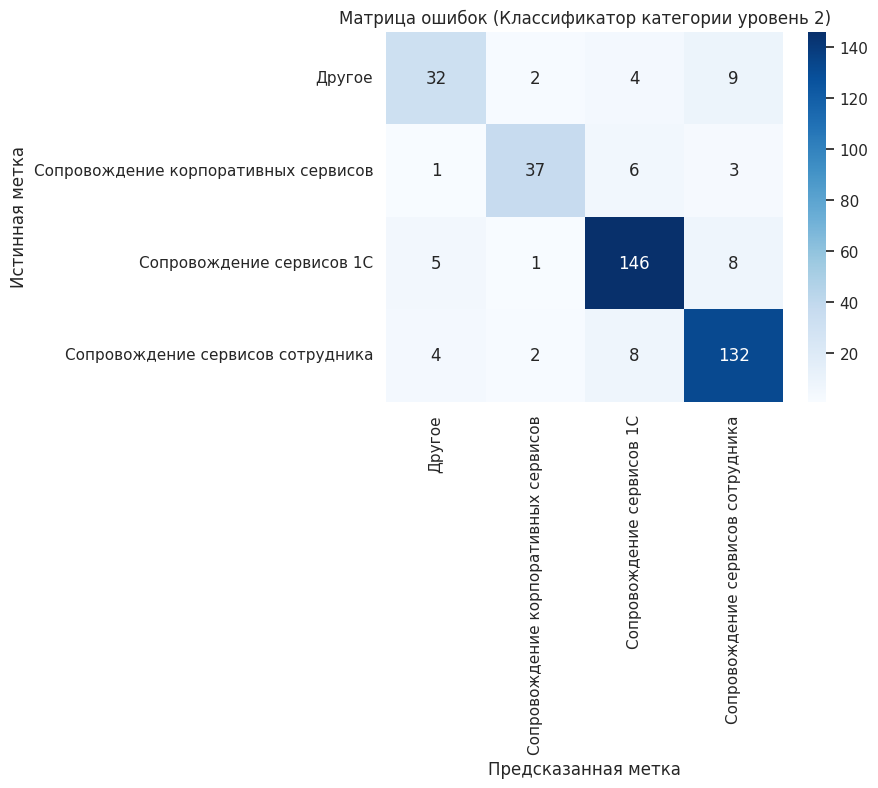

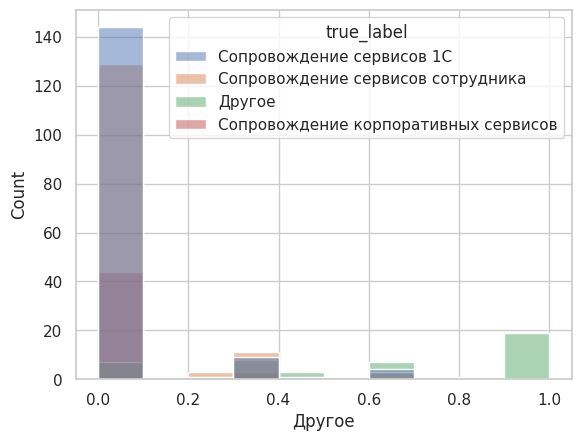

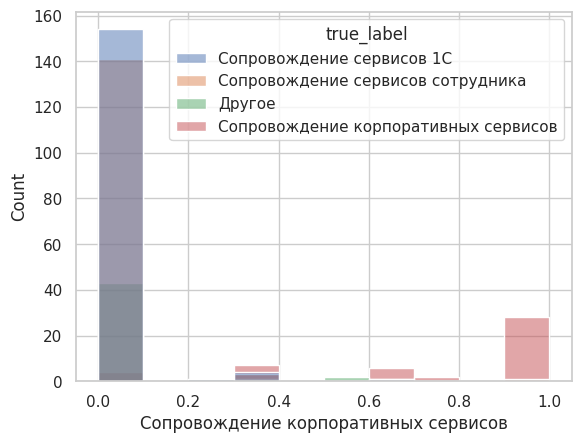

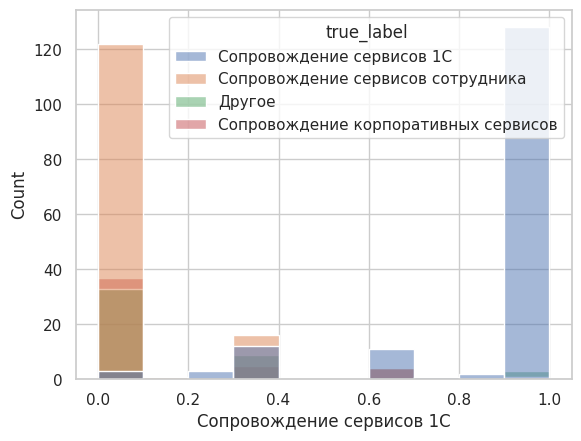

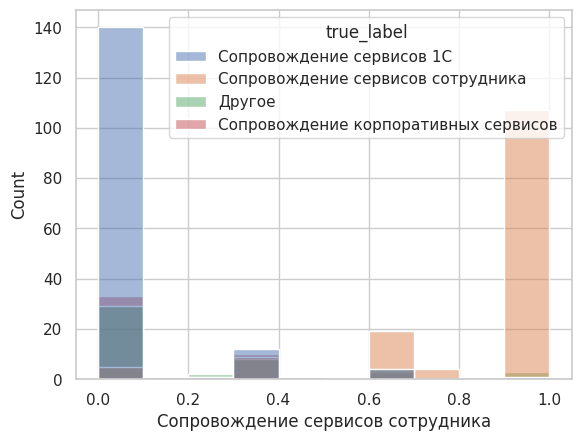

In [19]:
best_model_subj_desc, X_test, y_test, y_pred, y_proba = run_experiment(
    X_subj_desc, y, exp_name="Классификатор категории уровень 2"
)
run_eval(
    best_model_subj_desc,
    X_test,
    y_test,
    y_pred,
    y_proba,
    exp_name="Классификатор категории уровень 2",
)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


=== Отчёт по классификации (Классификатор назначения) ===
                                                     precision    recall  f1-score   support

                                             Другое       0.82      0.74      0.78       175
          Консультация по использованию функционала       0.65      0.72      0.68        18
                                Настройка нового ПК       0.90      0.90      0.90        20
                             Предоставление доступа       0.61      0.71      0.65        24
                                    Сброс пароля УЗ       0.68      0.88      0.76        57
                      Сопроводение справочников КАС       0.57      0.36      0.44        11
                        Сопровождение докуметов КАС       0.64      0.53      0.58        17
Сопровождение модулей личного кабинета обучающегося       0.67      0.40      0.50        10
                         Сопровождение приказов КАС       0.79      0.83      0.81        46
           

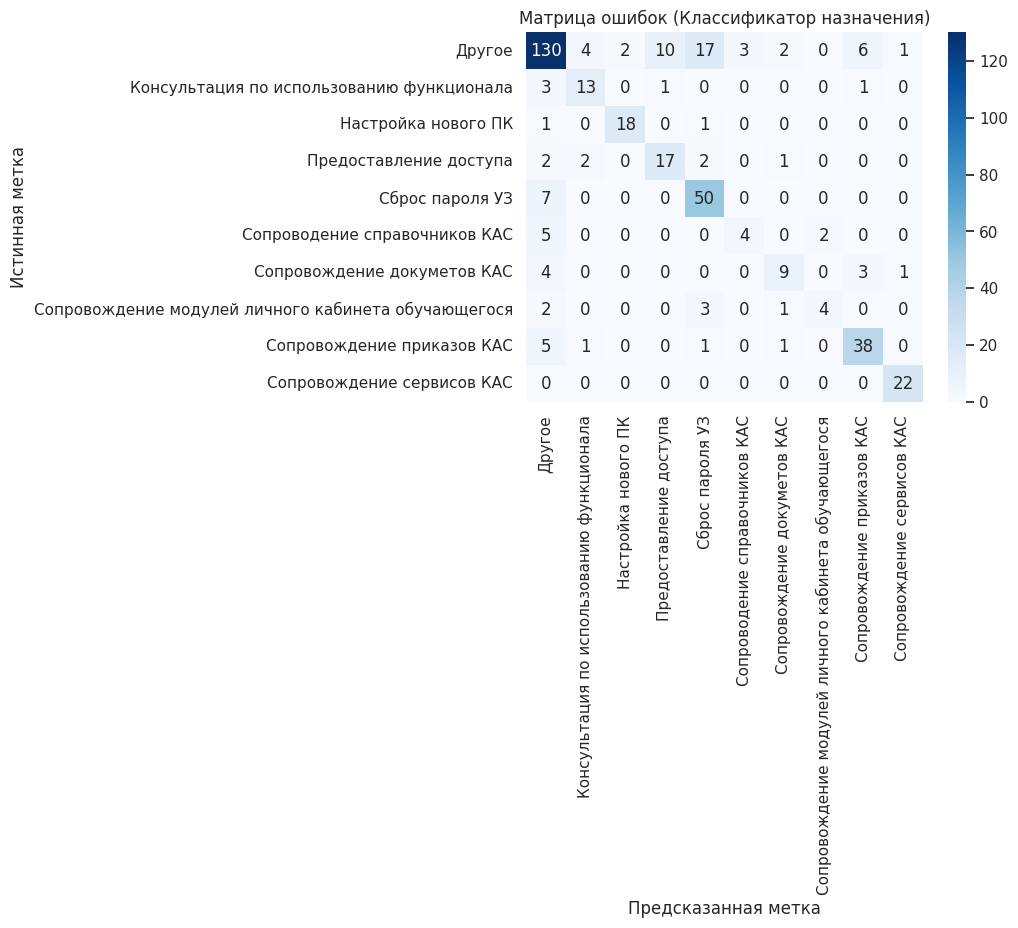

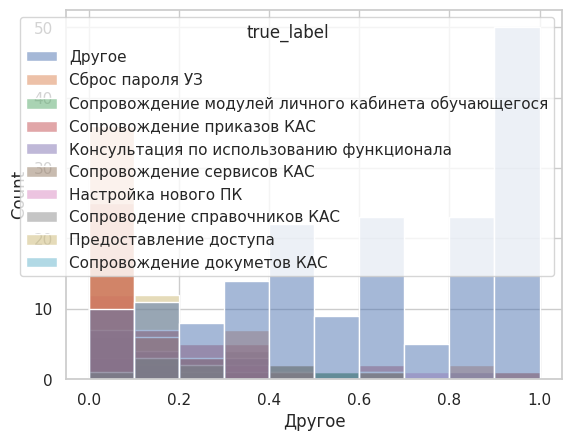

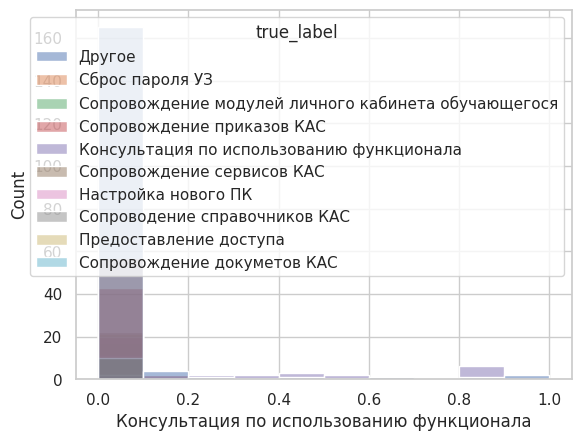

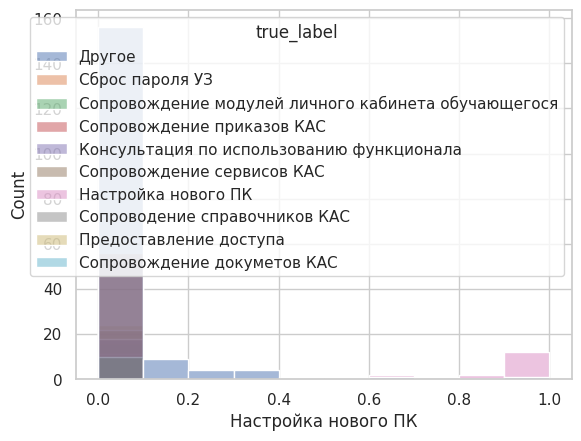

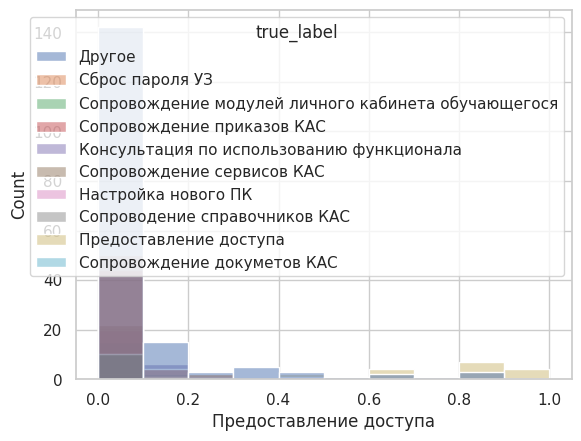

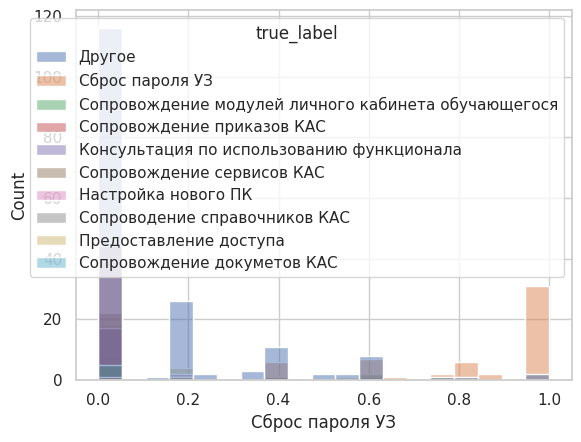

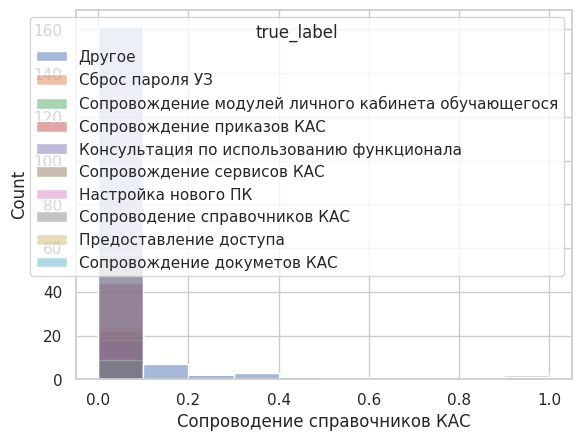

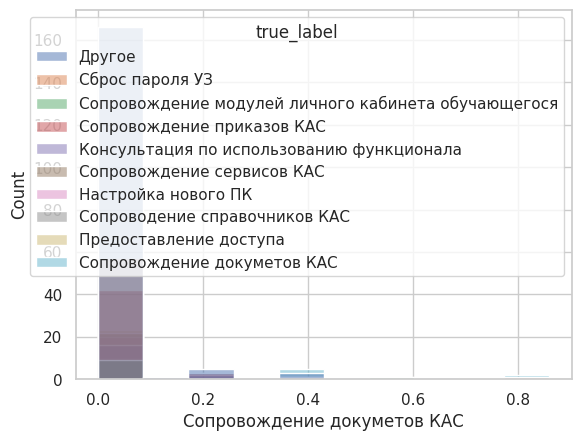

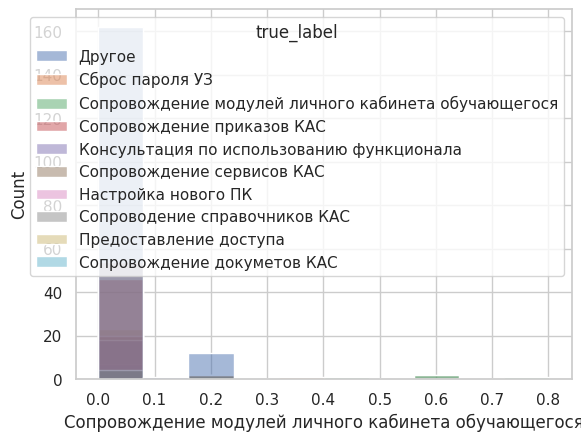

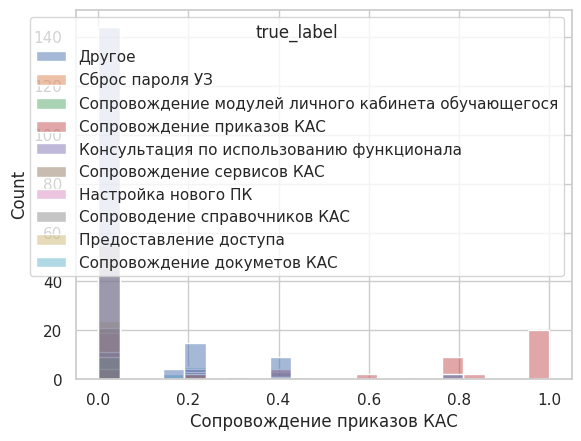

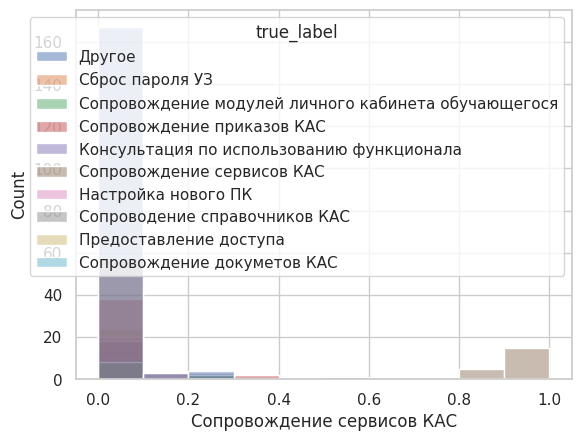

In [20]:
best_model_subj_desc, X_test, y_test, y_pred, y_proba = run_experiment(
    X_subj_desc, y1, exp_name="Классификатор назначения"
)
run_eval(
    best_model_subj_desc,
    X_test,
    y_test,
    y_pred,
    y_proba,
    exp_name="Классификатор назначения",
)

In [21]:
def search_opposite_class(query_embeddings, target_embeddings, topk=1):
    """
    Поиск ближайших соседей для заданных эмбеддингов запроса (query_embeddings)
    относительно эмбеддингов кандидатов (target_embeddings) с использованием FAISS.

    Параметры:
    - query_embeddings: numpy-массив эмбеддингов запросов
    - target_embeddings: numpy-массив эмбеддингов кандидатов
    - topk: количество ближайших соседей для поиска (по умолчанию 1)

    Возвращает:
    - distances: матрица расстояний для каждого запроса
    - indices: матрица индексов ближайших соседей
    """
    d = target_embeddings.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(target_embeddings)
    distances, indices = index.search(query_embeddings, topk)
    return distances, indices


def get_similar_items(data, y, description_embeddings, topk=5, output_path=None):
    """
    Извлекает список похожих айтемов, используя схему "один против всех" для многоклассовой задачи.

    Параметры:
    - data: DataFrame, содержащий колонку "description" и "id"
    - y: метки классов (numpy-массив или pd.Series)
    - description_embeddings: numpy-массив эмбеддингов, соответствующих строкам data
    - topk: количество ближайших соседей для поиска (по умолчанию 5)
    - output_path: путь для сохранения результатов в CSV (если None, CSV не сохраняется)

    Возвращает:
    - results_df: DataFrame с результатами, где каждая строка содержит:
         query_idx, candidate_idx, distance, query_text, candidate_text, query_class, candidate_class
    """
    # Фильтрация строк, где description не равен "no_description"
    mask = data["description"] != "no_description"
    data_filtered = data[mask].reset_index(drop=True)
    description_embeddings_filtered = description_embeddings[mask]
    y_filtered = np.array(y)[mask]

    # Получаем уникальные классы
    unique_classes = np.unique(y_filtered)
    results = []

    # Для каждого класса реализуем схему "один против всех"
    for cls in unique_classes:
        query_indices = np.where(y_filtered == cls)[0]
        target_indices = np.where(y_filtered != cls)[0]

        query_embeddings = description_embeddings_filtered[query_indices]
        target_embeddings = description_embeddings_filtered[target_indices]

        logger.info(f"Поиск похожих эмбеддингов для класса {cls} против остальных")
        distances, candidate_local_indices = search_opposite_class(
            query_embeddings, target_embeddings, topk=topk
        )

        # Преобразуем локальные индексы кандидатов в глобальные и сохраняем результаты
        for i, (dist_row, cand_indices) in enumerate(
            zip(distances, candidate_local_indices)
        ):
            query_global_idx = query_indices[i]
            global_cand_indices = [target_indices[cand] for cand in cand_indices]
            results.append((query_global_idx, global_cand_indices, dist_row.tolist()))

    # Сортируем результаты по расстоянию первого кандидата
    results_sorted = sorted(results, key=lambda x: x[2][0])

    # Формируем DataFrame с итоговыми данными
    res_data = []
    for query_idx, cand_list, dist_list in results_sorted:
        for cand_idx, dist in zip(cand_list, dist_list):
            query_text = data_filtered.loc[query_idx, "description"]
            candidate_text = data_filtered.loc[cand_idx, "description"]
            query_class = y_filtered[query_idx]
            candidate_class = y_filtered[cand_idx]
            res_data.append(
                {
                    "query_idx": data_filtered.loc[query_idx, "id"],
                    "candidate_idx": data_filtered.loc[cand_idx, "id"],
                    "distance": dist,
                    "query_text": query_text,
                    "candidate_text": candidate_text,
                    "query_class": query_class,
                    "candidate_class": candidate_class,
                }
            )
    results_df = pd.DataFrame(res_data)

    # Создаём ключ пары, который не зависит от порядка индексов, и удаляем дубликаты по нему
    results_df["pair_key"] = results_df.apply(
        lambda row: tuple(sorted([row["query_idx"], row["candidate_idx"]])), axis=1
    )
    results_df = results_df.drop_duplicates(subset=["pair_key"])
    results_df = results_df.drop(columns=["pair_key"])

    # Сохраняем результаты, если указан путь для сохранения CSV
    if output_path:
        results_df.to_csv(output_path, index=False)
        logger.info(f"Результаты поиска похожих эмбеддингов сохранены в {output_path}")

    return results_df


# Пример использования:
results_df = get_similar_items(
    data,
    y1,
    description_embeddings,
    topk=5,
)
print("Топ-10 наиболее похожих пар (по описанию):")
print(results_df.sort_values("distance").head(10).to_string(index=False))

2025-04-08 19:53:00,306 - INFO - Поиск похожих эмбеддингов для класса Другое против остальных


2025-04-08 19:53:00,469 - INFO - Поиск похожих эмбеддингов для класса Консультация по использованию функционала против остальных
2025-04-08 19:53:00,502 - INFO - Поиск похожих эмбеддингов для класса Настройка нового ПК против остальных
2025-04-08 19:53:00,509 - INFO - Поиск похожих эмбеддингов для класса Предоставление доступа против остальных
2025-04-08 19:53:00,516 - INFO - Поиск похожих эмбеддингов для класса Сброс пароля УЗ против остальных
2025-04-08 19:53:00,552 - INFO - Поиск похожих эмбеддингов для класса Сопроводение справочников КАС против остальных
2025-04-08 19:53:00,587 - INFO - Поиск похожих эмбеддингов для класса Сопровождение докуметов КАС против остальных
2025-04-08 19:53:00,622 - INFO - Поиск похожих эмбеддингов для класса Сопровождение модулей личного кабинета обучающегося против остальных
2025-04-08 19:53:00,656 - INFO - Поиск похожих эмбеддингов для класса Сопровождение приказов КАС против остальных
2025-04-08 19:53:00,691 - INFO - Поиск похожих эмбеддингов для кла

Топ-10 наиболее похожих пар (по описанию):
 query_idx candidate_idx  distance                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [10]:
results_df.sort_values("distance").head(100).to_excel(
    "../results/most_similar_100_level2.xlsx"
)

## Исправим ошибки